# Trees - Modelling

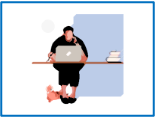

## PROBLEM: With given dataset, predict the probability of the payment within 90 days!

This is a small sample of data (both in terms of observations and available variables) that is actually used for training our models in *****. All the IDs are replaced, and all datapoints have a slight noise added to them to avoid any chance of identification. Data is stored as a small SQLite database stored in attached `session_9-Trees.db` file. There are two tables - `dataset` and `metadata`. The data sample spans 1 year and 30k observations.

In [78]:
# imports
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


In [79]:
import sqlite3
import pandas as pd
con = sqlite3.connect('session_9-Trees.db')

# information about the dataset
# exclude the column "index" and "varcode
metadata = pd.read_sql_query('SELECT * FROM metadata;', con)
metadata = metadata.drop(columns=['varcode'])
metadata


,name,var_class,entity_table
0,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months,variable,address
1,TargetAmount90Days,target,case
2,OriginalCapitalOfCaseInvoices,variable,case
3,AmountOfCase,variable,case
4,AgeOfDebt,variable,case
5,NumberOfTelephonesCI,variable,case
6,IndustryCode,variable,case
7,ClientName,variable,case
8,CustomerAge,variable,case
9,Target90Days,target,case


In [80]:
# read the data from the database
df = pd.read_sql_query('SELECT * FROM dataset;', con)
# rename the columns to the variable names. I hate the stupid codes
df = df.rename(columns={'a8404': 'RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months'})
df = df.rename(columns={'ap090': 'TargetAmount90Days'})
df = df.rename(columns={'c0001': 'OriginalCapitalOfCaseInvoices'})
df = df.rename(columns={'c0015': 'AmountOfCase'})
df = df.rename(columns={'c0019': 'AgeOfDebt'})
df = df.rename(columns={'c0031': 'NumberOfTelephonesCI'})
df = df.rename(columns={'c0039': 'IndustryCode'})
df = df.rename(columns={'c0044': 'ClientName'})
df = df.rename(columns={'c9008': 'CustomerAge'})
df = df.rename(columns={'ct090': 'Target90Days'})
df = df.rename(columns={'b0007': 'AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase'})
df = df.rename(columns={'d0009': 'AmountOfCustomerOpenCases'})
df = df.rename(columns={'d0012': 'LastOriginalClosingCodeOfCustomer'})
df = df.rename(columns={'d0027': 'NumberOfCustomerIncomingCallDatesTee'})
df = df.rename(columns={'d1205': 'NumberOfSuccessfullyClosedCasesInLast24Months'})
df = df.rename(columns={'d2112': 'NumberOfCustomerPaymentsInLast12Months'})
df = df.rename(columns={'d0031': 'NumberOfUnsuccessfullyClosedCustomerCasesLast36Months'})

### Some background information on the data

The intended target for prediction is `Target90Days`, `case_id` is the unique identifier, `keydate` is the point in time when some event has happened in the lifecycle of a case, and also a date relative to which all of the backward looking variables and forward looking targets are calculated. In this case, it's a general purpose propensity to pay model, which means that it is a freshly registered case, where all the relevant data has been gathered and verified. In other words, `keydate` is set a few days after registration, and target `Target90Days` is checking for outcome in 90 days (`TargetAmount90Days` is a similar regression target), while all the rest of the data is only looking backwards!

One more tip on interpretation of missing values: if variable is bound by time window, e.g. ` NumberOfCustomerPaymentsInLast12Months`, the `NA` value implies that there never have been any values, while `0` would mean that have been no values within bounding period (in this case 12 months). In other words, `0` and `NA` have different interpretation. It may or may not be relevant, depending on the choice of the modelling approach. 

### Some tips on the task

There is no end to seeking the perfection, and countless ways to approach this task. However, try not to approach this like a competition to crank out the highest possible accuracy metrics. What matters is the sequence and thought process - show this in illustrations and comments! Even if certain things might take too long to implement in a code, but you have a good idea where to go with this - write down your ideas! This is what matters.


# Solution

### 1. First look at the data

In [81]:
# Detailed assessment of the dataset

# General information about the dataset
info = df.info()

# Descriptive statistics for numerical variables but print it in a more readable way
descriptive_stats = df.describe().T 

# Distribution of the target variable 'Target90Days'
target_distribution = df['Target90Days'].value_counts(normalize=True)

info, descriptive_stats, target_distribution


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   case_id                                                           30000 non-null  int64  
 1   keydate                                                           30000 non-null  object 
 2   Target90Days                                                      30000 non-null  float64
 3   TargetAmount90Days                                                30000 non-null  float64
 4   OriginalCapitalOfCaseInvoices                                     29975 non-null  float64
 5   IndustryCode                                                      30000 non-null  object 
 6   ClientName                                                        30000 non-null  object 
 7   NumberOfUnsuccessfullyClosedCus

(None,
                                                                     count   
 case_id                                                           30000.0  \
 Target90Days                                                      30000.0   
 TargetAmount90Days                                                30000.0   
 OriginalCapitalOfCaseInvoices                                     29975.0   
 NumberOfUnsuccessfullyClosedCustomerCasesLast36Months             17371.0   
 AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase               13074.0   
 AmountOfCustomerOpenCases                                         30000.0   
 NumberOfTelephonesCI                                              30000.0   
 RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months  19599.0   
 AgeOfDebt                                                         30000.0   
 NumberOfCustomerIncomingCallDatesTee                              30000.0   
 CustomerAge                                             

My Observations:

#### Dataset Structure and Variable Types
- The `keydate` column is of object type, which suggests it is in string format and should be converted to datetime for any time-based analysis.
- The `IndustryCode` and `LastOriginalClosingCodeOfCustomer` are categorical, with the latter represented as an integer.

#### Missing Values

- Several columns have missing values, notably `NumberOfUnsuccessfullyClosedCustomerCasesLast36Months`, `AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase`, `CustomerAge`, `NumberOfCustomerPaymentsInLast12Months`, and `NumberOfSuccessfullyClosedCasesInLast24Months`. The extent of missingness varies, with some columns missing more than half of their values.

#### Descriptive Stats

- **Target Variables**: The target variable `Target90Days` is binary, with approximately 83.13% of cases marked as 0 (no payment within 90 days) and 16.87% marked as 1 (payment made within 90 days). This can suggest an imbalance in the distribution of the target variable.
- **Numerical Variables**: Variables like `AmountOfCase`, `AgeOfDebt`, and `OriginalCapitalOfCaseInvoices` have a wide range of values, indicating variability in the amounts and ages associated with the cases. The presence of outliers, especially in the `AmountOfCase` variable, is suggested by the large difference between the mean and median values, and the significant spread between the 75th percentile and the maximum values.

#### My Takeaways

- The imbalance in the distribution of the target variable suggests that techniques to address imbalanced datasets may be necessary when building predictive models.
- The presence of missing values, particularly where `NA` and `0` have different meanings, will require careful handling. Strategies may include imputation for some variables and special treatment or encoding for others to capture the significance of `NA` versus `0`.
- The dataset includes a mix of potentially predictive variables, ranging from case-specific details (e.g., `OriginalCapitalOfCaseInvoices`, `AgeOfDebt`) to debtor behavior (e.g., `NumberOfCustomerPaymentsInLast12Months`, `NumberOfSuccessfullyClosedCasesInLast24Months`).

### 2. Implement an Exploratory Data Analysis (EDA) and draw some practical conclusions (correlations)

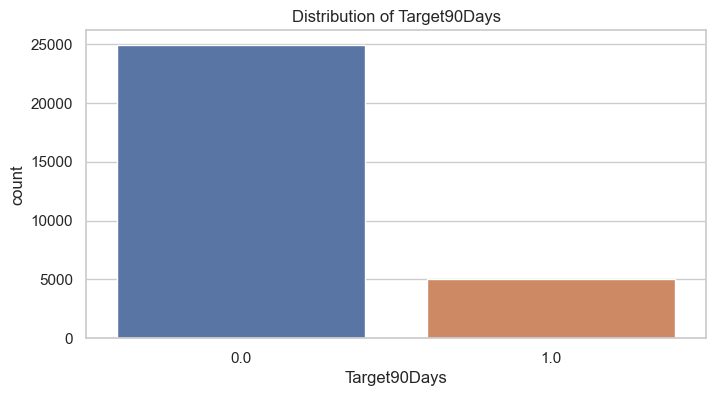

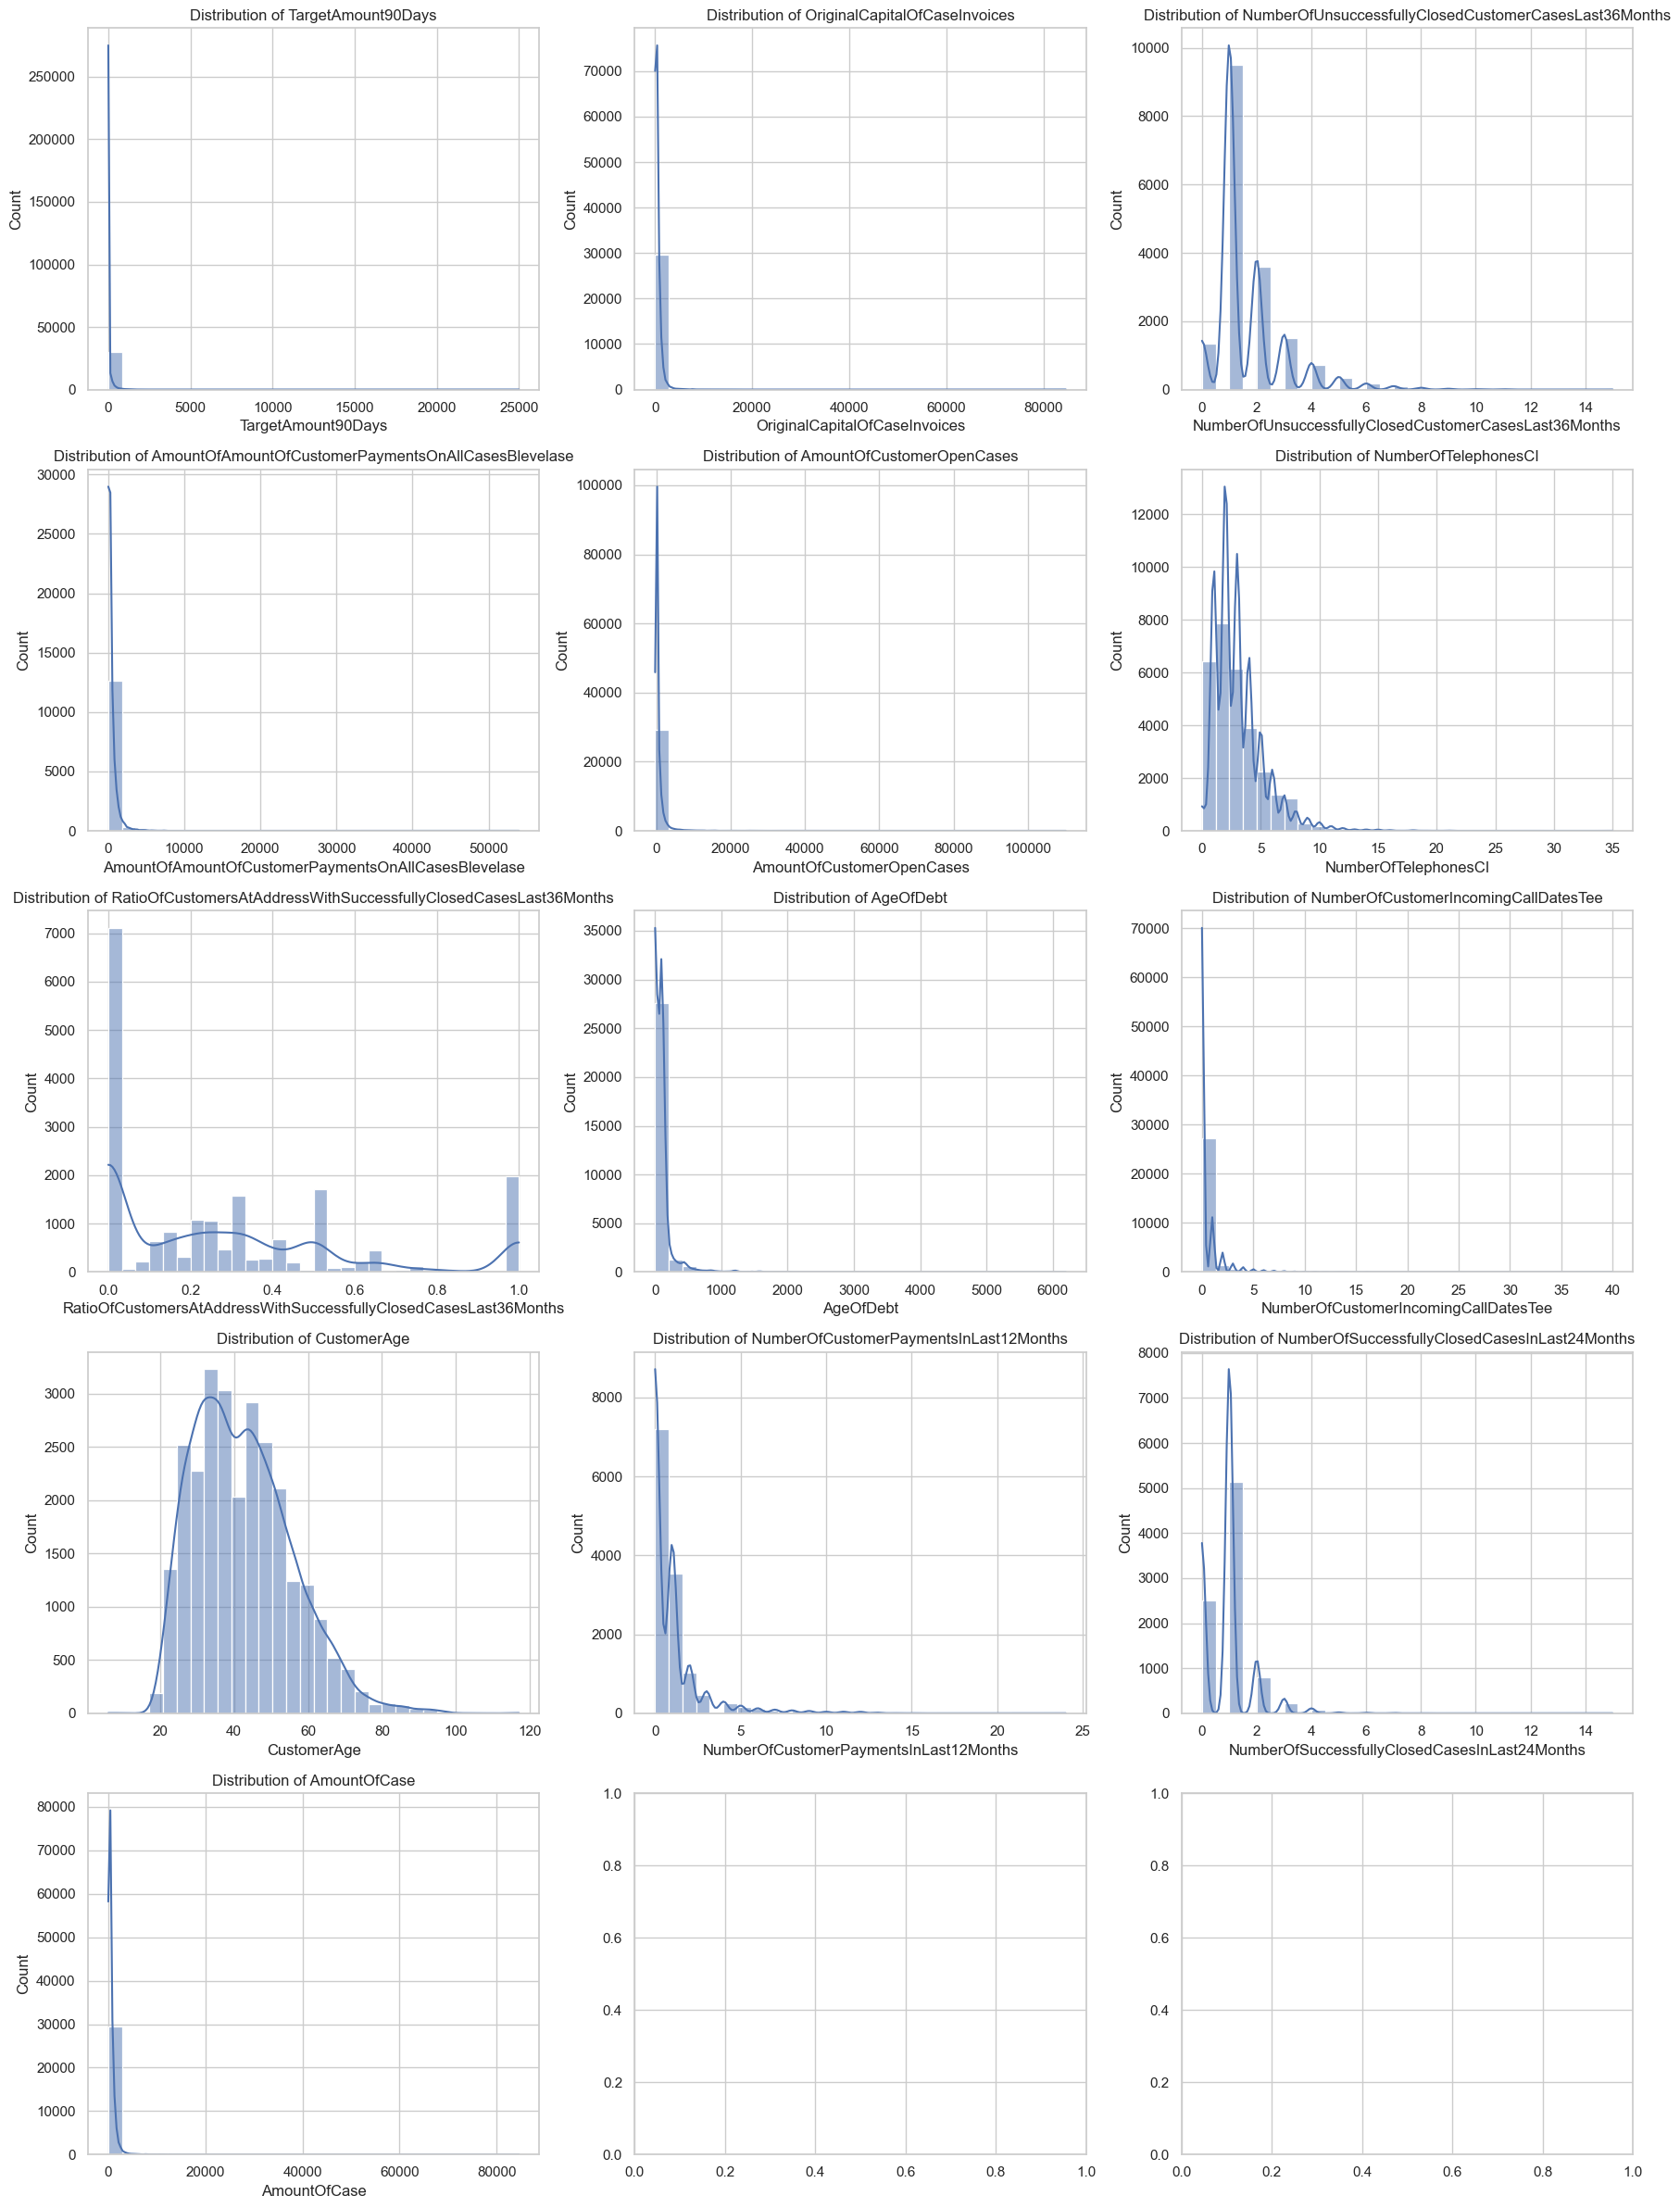

In [82]:
# Setting the aesthetics for the plots (aestjetic is key)
sns.set(style="whitegrid")

# Univariate Analysis: Visualizing the distribution of the target variable 'Target90Days'
plt.figure(figsize=(8, 4))
sns.countplot(x='Target90Days', data=df)
plt.title('Distribution of Target90Days')
plt.show()

# Visualizing the distribution of all numerical variables
fig, ax = plt.subplots(5, 3, figsize=(18, 24))

# List of all numerical variables to plot, excluding 'Target90Days' as it's binary
numerical_variables = [
    'TargetAmount90Days',
    'OriginalCapitalOfCaseInvoices',
    'NumberOfUnsuccessfullyClosedCustomerCasesLast36Months',
    'AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase',
    'AmountOfCustomerOpenCases',
    'NumberOfTelephonesCI',
    'RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months',
    'AgeOfDebt',
    'NumberOfCustomerIncomingCallDatesTee',
    'CustomerAge',
    'NumberOfCustomerPaymentsInLast12Months',
    'NumberOfSuccessfullyClosedCasesInLast24Months',
    'AmountOfCase'
]

# Plotting
for i, var in enumerate(numerical_variables):
    sns.histplot(df[var], kde=True, ax=ax[i//3, i%3], bins=30).set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()


#### Univariate Analysis

- **Distribution of `Target90Days`**: The target variable shows a significant imbalance, with a majority of the cases not making a payment within 90 days. This imbalance will need to be addressed during model training to ensure that the model does not become biased towards predicting the majority class.

Numerical Variables:

- **Right-Skewed Distributions**: Many of the variables, such as `TargetAmount90Days`, `OriginalCapitalOfCaseInvoices`, `AmountOfCustomerOpenCases`, and `AmountOfCase`, show right-skewed distributions. This indicates the presence of outliers with high values, which is common in financial data.

- **Sparse Data**: Variables like `NumberOfUnsuccessfullyClosedCustomerCasesLast36Months`, `AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase`, `NumberOfCustomerPaymentsInLast12Months`, and `NumberOfSuccessfullyClosedCasesInLast24Months` demonstrate a high concentration of values near zero, reflecting sparsity in these events.

- **Variability in Age and Ratio Variables**: `AgeOfDebt` and `CustomerAge` show a wide range of values, with `AgeOfDebt` being particularly right-skewed, indicating debts of varying ages, including some very old debts. The `RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months` also exhibits a diverse distribution, suggesting variability in the success rates at different addresses.

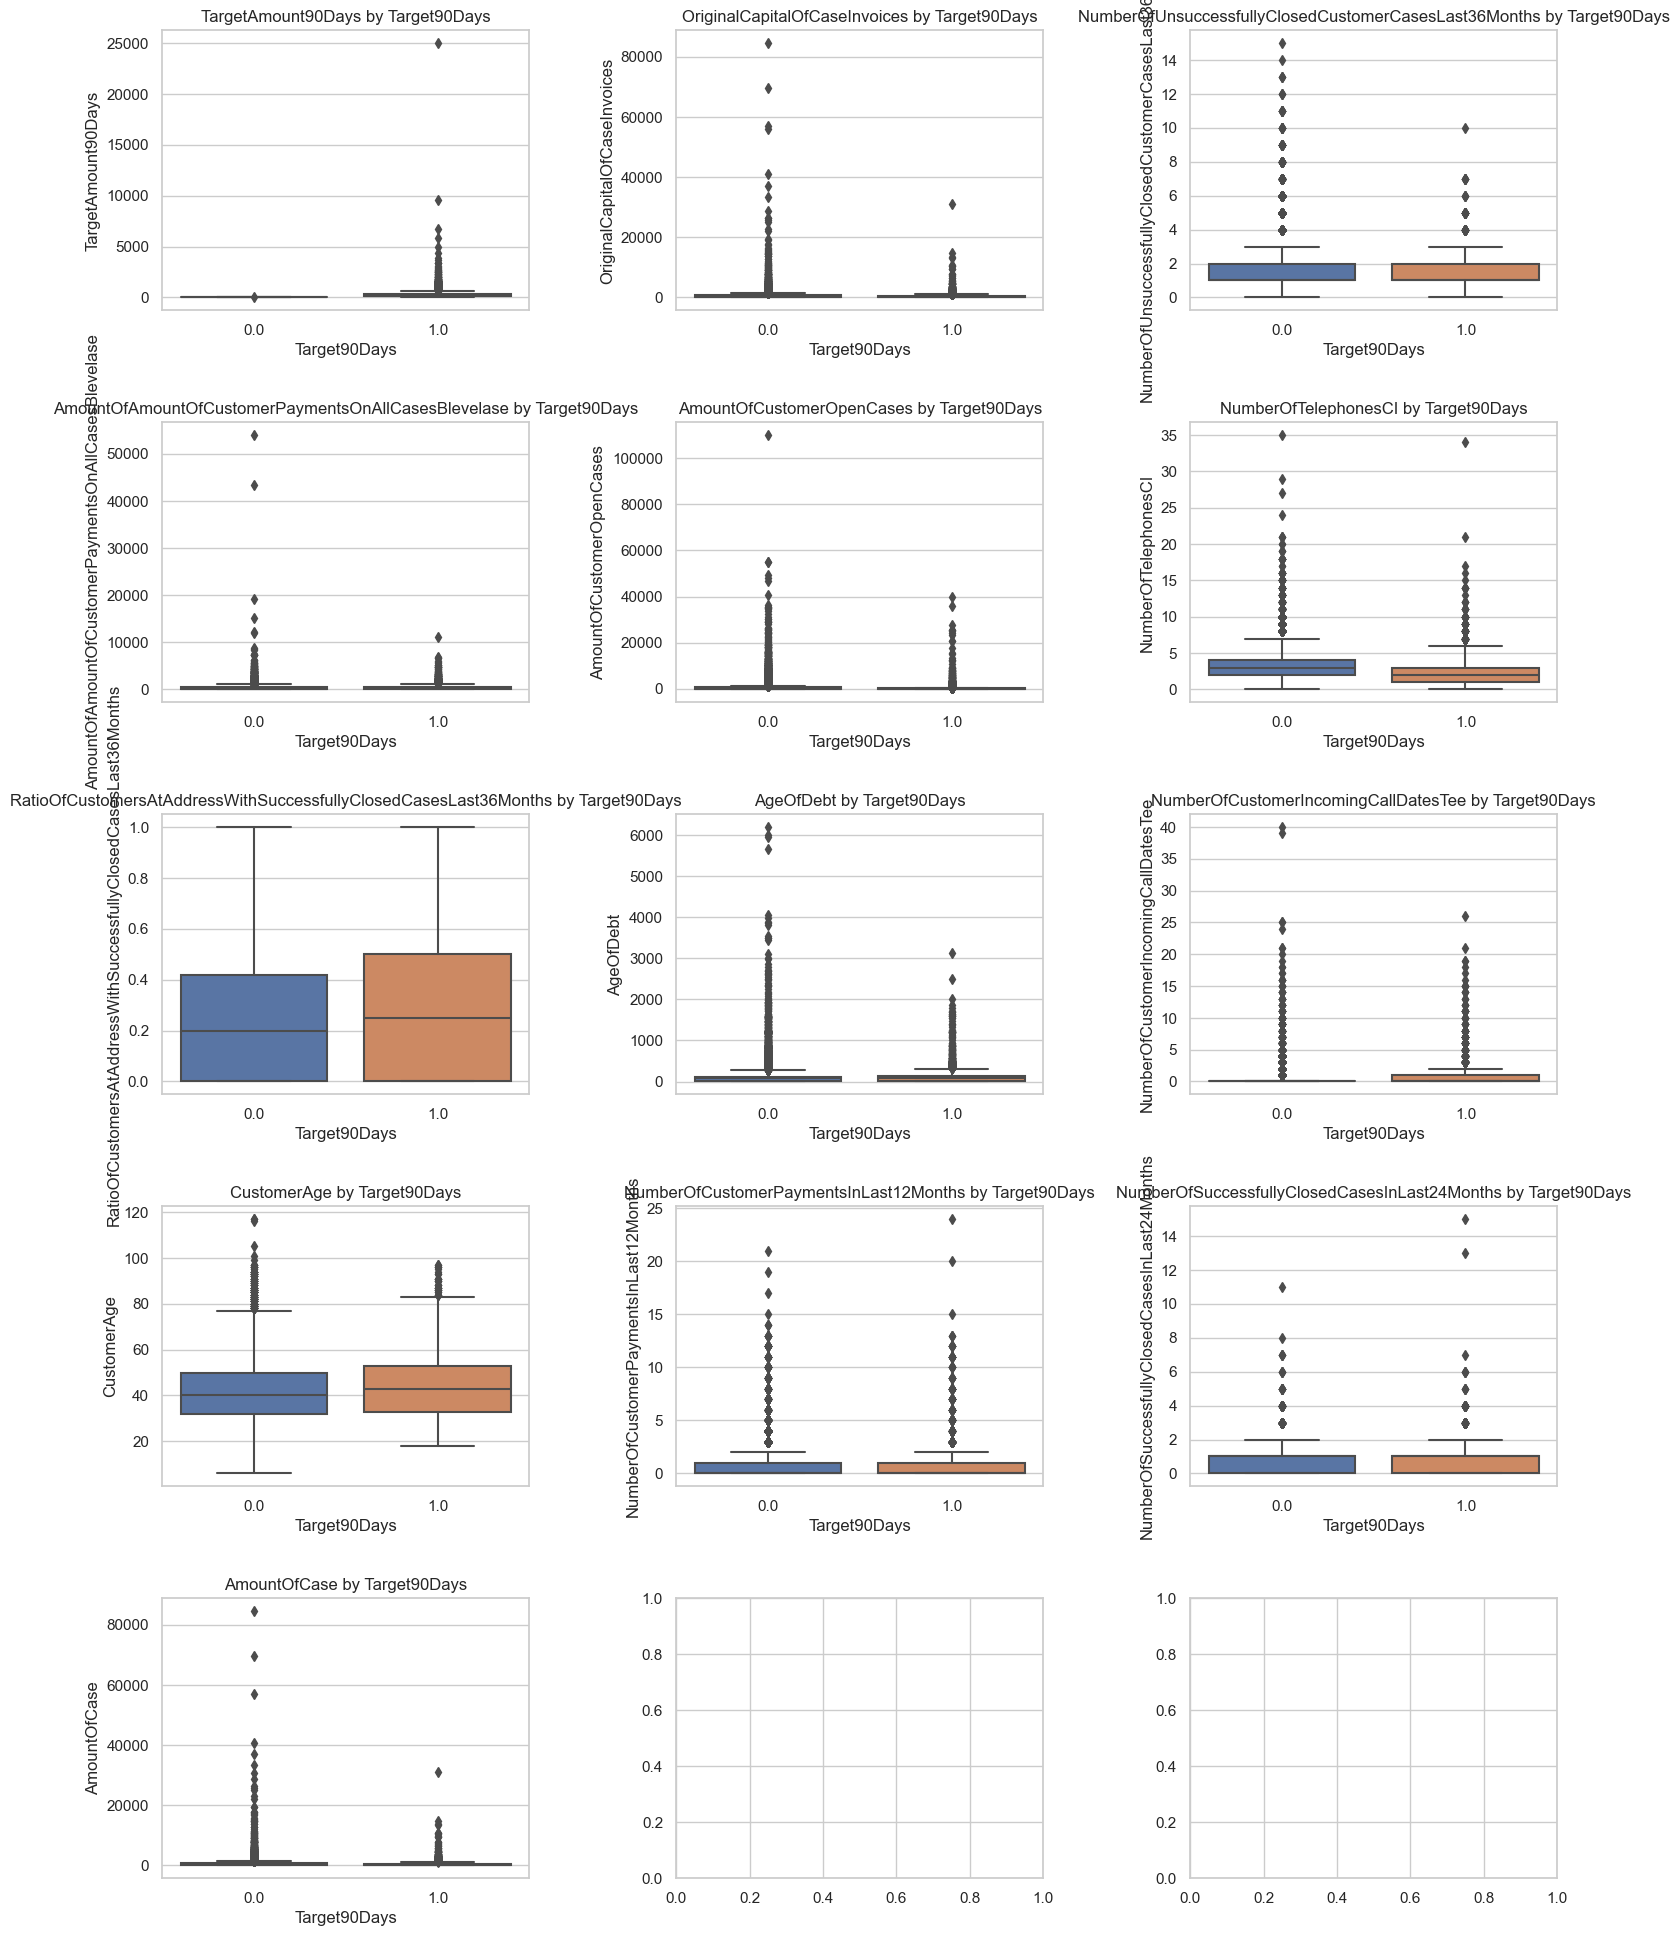

In [83]:
# Bivariate Analysis: Visualizing the relationship between 'Target90Days' and all necessary numerical variables

fig, ax = plt.subplots(5, 3, figsize=(18, 24))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Excluding 'Target90Days' itself and focusing on numerical variables for bivariate analysis
for i, var in enumerate(numerical_variables):
    sns.boxplot(x='Target90Days', y=var, data=df, ax=ax[i//3, i%3]).set_title(f'{var} by Target90Days')

plt.show()


#### Bivariate Analysis
- **Target Amount and Original Capital**: For both `TargetAmount90Days` and `OriginalCapitalOfCaseInvoices`, the distributions suggest that higher amounts might slightly correlate with an increased likelihood of payment within 90 days, although the effect is subtle, and there's considerable overlap between the two categories.

- **Unsuccessfully Closed Cases and Payments**: The number of `NumberOfUnsuccessfullyClosedCustomerCasesLast36Months` and `AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase` show some differences between the two target classes, indicating that past payment behavior and case closure outcomes may influence the probability of payment within 90 days.

- **Open Cases and Telecommunications**: `AmountOfCustomerOpenCases` and `NumberOfTelephonesCI` distributions indicate that the level of current indebtedness and the intensity of telecommunications might not have a stark difference in predicting the payment within 90 days, suggesting that while these factors are relevant, they might not be decisive on their own.

- **Debt Age and Customer Age**: Interestingly, `AgeOfDebt` and `CustomerAge` show that older debts and possibly older customers do not significantly differ in their payment probability within 90 days, based on the target variable. This could imply that the age of the debt or the debtor might not be as critical in predicting short-term payment behavior.

- **Payment Ratios and Recent Payments**: Variables like `RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months` and `NumberOfCustomerPaymentsInLast12Months` offer nuanced insights. A higher ratio of successfully closed cases at an address and recent payment activity might be associated with a higher likelihood of payment within 90 days, suggesting the importance of historical payment success and recent engagement with debt obligations.

- **Successfully Closed Cases**: The `NumberOfSuccessfullyClosedCasesInLast24Months` seems to show a slight difference between the groups, which might imply that a history of successfully closing cases could influence payment behavior positively.

Takeaways:

- **Past Behavior as a Predictor**: Past payment behavior and the outcome of previous cases are informative for predicting future payment probabilities.
- **Quantitative Factors**: While financial amounts (e.g., original capital, target amount) are relevant, the relationships are complex and require nuanced modeling to capture effectively.
- **Customer Engagement**: Indicators of customer engagement, such as recent payments or telecommunications, could be important features in the predictive model.
- **Age Factors**: The age of the debt and the debtor, while informative, may not be as predictive of payment within 90 days as other variables, suggesting that other factors play a more significant role in the short term.

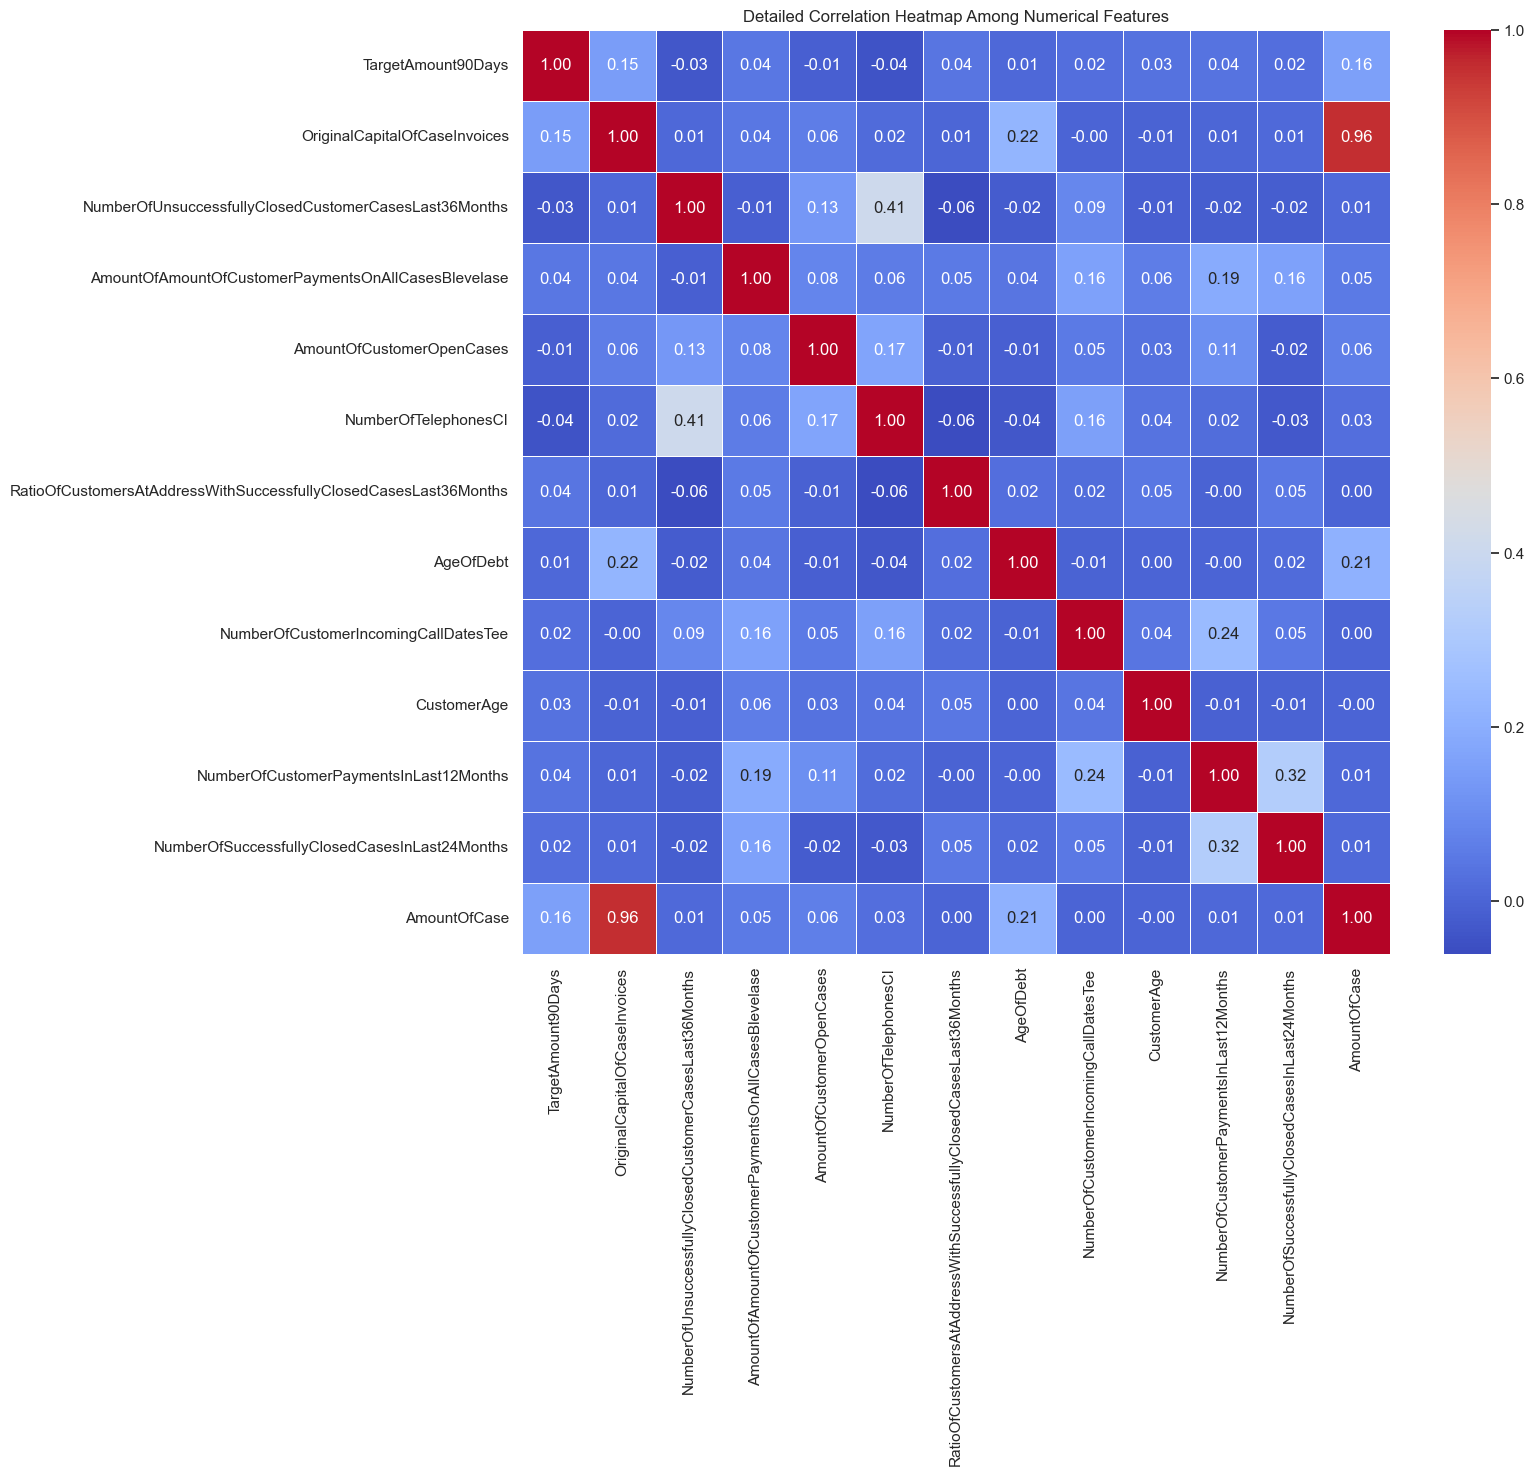

In [84]:
# Correlation heatmap among features with an updated and more detailed view
plt.figure(figsize=(14, 12))
correlation_matrix = df[numerical_variables].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Detailed Correlation Heatmap Among Numerical Features')
plt.show()


#### Correlation Analysis

- **Low to Moderate Correlations**: Most variables exhibit low to moderate correlations with each other, indicating that there's no strong linear dependency between most pairs of features. This is generally positive for modeling, as it suggests less multicollinearity, allowing models like tree-based algorithms to better distinguish the unique contribution of each feature.

- **Financial Amounts Related**: There are some expected correlations between financial amounts, such as between `OriginalCapitalOfCaseInvoices` and `AmountOfCase`. These correlations are natural, given that they both relate to the financial aspects of the cases. However, the correlation coefficients are not so high as to indicate redundancy.

- **Customer Behavior and Payment History**: Variables related to customer behavior and payment history, like `NumberOfCustomerPaymentsInLast12Months` and `AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase`, show some level of correlation. This suggests that past payment behaviors are somewhat consistent and could be predictive of future behaviors.

- **Age and Ratio Variables**: `AgeOfDebt` shows very low correlation with most other variables, indicating its unique contribution to the dataset. Similarly, `RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months` and `CustomerAge` do not strongly correlate with other features, suggesting they could provide distinct information to the predictive models.

### Insights for Modeling

- **Feature Selection**: The low to moderate correlations suggest that many of the features can contribute unique information to the predictive models, supporting the inclusion of a broad set of features for initial modeling efforts.

- **Redundancy Checks**: While some financial variables are correlated, the correlations are not so strong as to necessitate immediate exclusion for redundancy. However, feature importance analysis during model training can help identify if any of these correlated features do not significantly contribute to model performance.

- **Behavioral and Historical Features**: The correlations among variables related to customer behavior and payment history underline the potential value of these features in predicting payment outcomes. These features should be closely examined during feature engineering and modeling for their predictive power.

- **Unique Contributions**: Variables with low correlations across the board, such as `AgeOfDebt`, offer unique information and should be carefully considered in the modeling process to ensure that their potential contribution is not overlooked.

### 3. Work with missing values and draw some conclusions

In [85]:
# Analysis of Missingness: Calculating the percentage of missing values for each column in the dataset
missing_values = df.isnull().mean() * 100

# Display the percentage of missing values for each column
missing_values_analysis = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values_analysis


NumberOfSuccessfullyClosedCasesInLast24Months                       70.793333
NumberOfCustomerPaymentsInLast12Months                              56.506667
AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase                 56.420000
NumberOfUnsuccessfullyClosedCustomerCasesLast36Months               42.096667
RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months    34.670000
CustomerAge                                                          9.946667
OriginalCapitalOfCaseInvoices                                        0.083333
dtype: float64

### Interpretation

- **Informative Missingness**: For variables bound by a time window (e.g., `NumberOfCustomerPaymentsInLast12Months`), NA values imply no historical data, while `0` indicates no activity within the specified period. This distinction is crucial for modeling, as it provides insight into the debtor's behavior.

### Game Plan for Handling Missing Data

Given the context and the nature of missingness, the following strategies can be applied:

1. **Imputation**:
   - For `CustomerAge` and `OriginalCapitalOfCaseInvoices` with relatively low missingness, consider using imputation based on median values or other statistical methods like KNN imputation, which can account for the relationships between variables.

2. **Flagging and Filling**:
   - For variables with informative missingness, such as `NumberOfCustomerPaymentsInLast12Months`, consider flagging (creating a binary indicator for missingness) and filling NAs with `0`. This approach retains information about the lack of historical data or activity.

3. **Exclusion or Advanced Imputation**:
   - Variables with very high missingness, like `NumberOfSuccessfullyClosedCasesInLast24Months`, pose a challenge. Depending on the model's sensitivity to missing data, consider either excluding these variables if they do not contribute significantly to predictive power or applying advanced imputation techniques that consider the entire dataset's structure.

4. **Modeling Choices**:
   - Some algorithms I will use can inherently handle missing values (XGBoost), reducing the need for extensive imputation and allowing the model to learn from the pattern of missingness itself.


In [86]:
# imputation
# Creating an imputer object with a strategy of median for numerical columns
imputer = SimpleImputer(strategy='median')

# Columns to impute
columns_to_impute = ['CustomerAge', 'OriginalCapitalOfCaseInvoices']

# Applying the imputation
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Checking if the imputation was successful by calculating the percentage of missing values again for these columns
missing_values_post_imputation = df[columns_to_impute].isnull().mean() * 100
missing_values_post_imputation


CustomerAge                      0.0
OriginalCapitalOfCaseInvoices    0.0
dtype: float64

In [88]:
# Flagging and filling: This my first time (birds always say that lol)

# Variables with informative missingness
informative_missingness_vars = [
    'NumberOfSuccessfullyClosedCasesInLast24Months',
    'NumberOfCustomerPaymentsInLast12Months',
    'AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase',
    'NumberOfUnsuccessfullyClosedCustomerCasesLast36Months',
    'RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months'
]

# Creating binary indicators for missingness and filling NAs with 0
for var in informative_missingness_vars:
    # Creating a binary indicator for missingness
    df[var + '_missing'] = df[var].isnull().astype(int)
    
    # Filling NA values with 0
    df[var].fillna(0, inplace=True)

# Checking the result
df[informative_missingness_vars + [var + '_missing' for var in informative_missingness_vars]].head()


,NumberOfSuccessfullyClosedCasesInLast24Months,NumberOfCustomerPaymentsInLast12Months,AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase,NumberOfUnsuccessfullyClosedCustomerCasesLast36Months,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months,NumberOfSuccessfullyClosedCasesInLast24Months_missing,NumberOfCustomerPaymentsInLast12Months_missing,AmountOfAmountOfCustomerPaymentsOnAllCasesBlevelase_missing,NumberOfUnsuccessfullyClosedCustomerCasesLast36Months_missing,RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months_missing
0,0.0,0.0,0.00,2.0,0.0,1,0,0,0,1
1,1.0,0.0,210.53,0.0,0.0,0,0,0,1,1
2,0.0,0.0,0.00,1.0,0.0,1,1,1,0,0
3,0.0,0.0,0.00,0.0,1.0,1,1,1,1,0
4,0.0,0.0,20.00,2.0,0.0,1,0,0,0,1


### Feature engineering

### Features importance

### Modeling: solve the problem and compare several models

* Random Forest
* Gradient Boosting
* XGBoost
* LightGMB
* Others